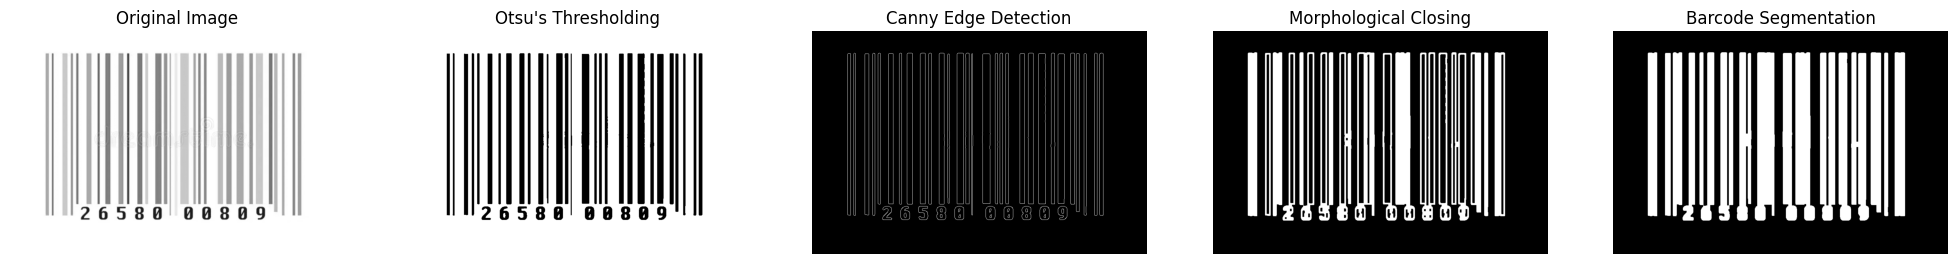

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread('bar2.png', cv2.IMREAD_GRAYSCALE)


#Blur to reduce noise
blurred = cv2.GaussianBlur(image, (5, 5), 0)

#Otsu's Thresholdingapplies thresholding to convert the grayscale image into a binary (black and white) image.
#Pixels above this threshold become white (255), and those below become black (0).
_, otsu_thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

#Apply Canny Edge Detection
# Gradients above high_threshold are edges.
#Gradients between low_threshold and high_threshold are edges only if connected to strong edges.

low_threshold = 50
high_threshold = 150
edges = cv2.Canny(otsu_thresh, low_threshold, high_threshold)

#Morphological operations to connect broken lines
kernel = np.ones((3, 3), np.uint8)
dilated = cv2.dilate(edges, kernel, iterations=2)
closed = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel, iterations=2)

# Fill inside edges
barcode_segment = np.zeros_like(image)
contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(barcode_segment, contours, -1, 255, thickness=cv2.FILLED)

#Visualize
fig, axs = plt.subplots(1, 5, figsize=(25, 5))

# Original Image
axs[0].imshow(image, cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')

# Otsu's Thresholding
axs[1].imshow(otsu_thresh, cmap='gray')
axs[1].set_title("Otsu's Thresholding")
axs[1].axis('off')

# Canny Edges
axs[2].imshow(edges, cmap='gray')
axs[2].set_title('Canny Edge Detection')
axs[2].axis('off')

# Morphological Closing
axs[3].imshow(closed, cmap='gray')
axs[3].set_title('Morphological Closing')
axs[3].axis('off')

# Barcode Segmentation
axs[4].imshow(barcode_segment, cmap='gray')
axs[4].set_title('Barcode Segmentation')
axs[4].axis('off')

plt.show()


In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

In [3]:
from datasets import load_dataset

ds = load_dataset("huggan/cityscapes")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/799 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


dataset_infos.json:   0%|          | 0.00/709 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/433M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3475 [00:00<?, ? examples/s]

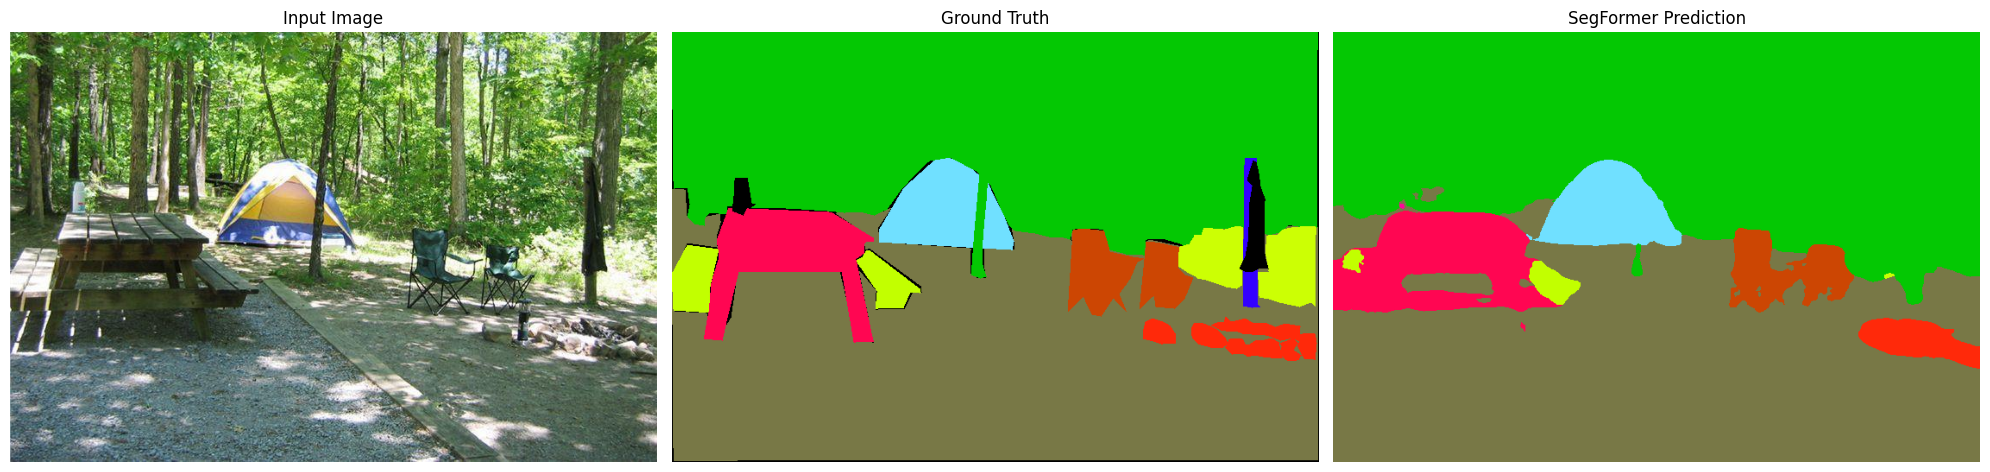

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoImageProcessor, SegformerForSemanticSegmentation
from datasets import load_dataset

# Load ADE20K validation dataset
dataset = load_dataset("scene_parse_150", split="train")

# Load SegFormer-B5 model pretrained on ADE20K
model_name = "nvidia/segformer-b5-finetuned-ade-640-640"
processor = AutoImageProcessor.from_pretrained(model_name)
model = SegformerForSemanticSegmentation.from_pretrained(model_name)

# Official ADE20K colormap (151 entries: 0=void, 1-150=classes)
colormap = np.array([
    [0, 0, 0], [120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
    [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255], [230, 230, 230],
    [4, 250, 7], [224, 5, 255], [235, 255, 7], [150, 5, 61], [120, 120, 70],
    [8, 255, 51], [255, 6, 82], [143, 255, 140], [204, 255, 4], [255, 51, 7],
    [204, 70, 3], [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
    [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220], [255, 9, 92],
    [112, 9, 255], [8, 255, 214], [7, 255, 224], [255, 184, 6], [10, 255, 71],
    [255, 41, 10], [7, 255, 255], [224, 255, 8], [102, 8, 255], [255, 61, 6],
    [255, 194, 7], [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
    [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255], [140, 140, 140],
    [250, 10, 15], [20, 255, 0], [31, 255, 0], [255, 31, 0], [255, 224, 0],
    [153, 255, 0], [0, 0, 255], [255, 71, 0], [0, 235, 255], [0, 173, 255],
    [31, 0, 255], [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
    [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0], [255, 102, 0],
    [194, 255, 0], [0, 143, 255], [51, 255, 0], [0, 82, 255], [0, 255, 41],
    [0, 255, 173], [10, 0, 255], [173, 255, 0], [0, 255, 153], [255, 92, 0],
    [255, 0, 255], [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
    [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255], [255, 0, 204],
    [0, 255, 194], [0, 255, 82], [0, 10, 255], [0, 112, 255], [51, 0, 255],
    [0, 194, 255], [0, 122, 255], [0, 255, 163], [255, 153, 0], [0, 255, 10],
    [255, 112, 0], [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
    [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255], [255, 0, 31],
    [0, 184, 255], [0, 214, 255], [255, 0, 112], [92, 255, 0], [0, 224, 255],
    [112, 224, 255], [70, 184, 160], [163, 0, 255], [153, 0, 255], [71, 255, 0],
    [255, 0, 163], [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
    [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0], [10, 190, 212],
    [214, 255, 0], [0, 204, 255], [20, 0, 255], [255, 255, 0], [0, 153, 255],
    [0, 41, 255], [0, 255, 204], [41, 0, 255], [41, 255, 0], [173, 0, 255],
    [0, 245, 255], [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
    [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194], [102, 255, 0],
    [92, 0, 255]
], dtype=np.uint8)

# Pad to 151 entries if needed
if len(colormap) < 151:
    colormap = np.vstack([colormap, np.zeros((151 - len(colormap), 3), dtype=np.uint8)])

# Select image index to test
idx = 100 # Try different indices (0-2000)
image = dataset[idx]["image"]
annotation = np.array(dataset[idx]["annotation"])

# Preprocess and run inference
inputs = processor(images=image, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)

# Postprocess predictions
predicted_mask = processor.post_process_semantic_segmentation(
    outputs,
    target_sizes=[image.size[::-1]]  # (height, width)
)[0]

# Convert predictions to 1-based indexing for ADE20K colormap
predicted_mask += 1

# Create visualization
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Input image
ax1.imshow(image)
ax1.set_title("Input Image")
ax1.axis("off")

# Ground truth
ax2.imshow(colormap[annotation])
ax2.set_title("Ground Truth")
ax2.axis("off")

# Prediction
ax3.imshow(colormap[predicted_mask.numpy().astype(np.uint8)])
ax3.set_title("SegFormer Prediction")
ax3.axis("off")

plt.tight_layout()
plt.show()